In [1]:
import urllib.request
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox

import os
import numpy as np
from subprocess import call
import warnings

In [2]:
# Useful but not essential dependency
# (https://github.com/toobaz/generic_utils)
try:
    from generic_utils.counter import Counter
except ImportError:
    class Counter:
        def __init__(self, *args, **kwargs):
            pass
        def count(self, *args, **kwargs):
            pass

In [3]:
#resp = urllib.request.urlopen('https://maphub.net/json/map_load/176607')
#with open('176607.json', 'wb') as fout:
#    fout.write(resp.read())
# HTTPError: HTTP Error 403: Forbidden

# ... wants POST, but not worth the effort.

... after manual download...

In [4]:
full_data = pd.read_json('176607.json')

In [5]:
full_data.shape

(11, 16)

In [6]:
full_data

success                        name  \
type                True  Russia-Ukraine Monitor Map   
features            True  Russia-Ukraine Monitor Map   
groups              True  Russia-Ukraine Monitor Map   
markers             True  Russia-Ukraine Monitor Map   
properties          True  Russia-Ukraine Monitor Map   
west                True  Russia-Ukraine Monitor Map   
south               True  Russia-Ukraine Monitor Map   
east                True  Russia-Ukraine Monitor Map   
north               True  Russia-Ukraine Monitor Map   
ui_controls         True  Russia-Ukraine Monitor Map   
use_system_font     True  Russia-Ukraine Monitor Map   

                                                       description  \
type             The Russia-Ukraine Monitor Map is a crowdsourc...   
features         The Russia-Ukraine Monitor Map is a crowdsourc...   
groups           The Russia-Ukraine Monitor Map is a crowdsourc...   
markers          The Russia-Ukraine Monitor Map is a crowdsourc...   
properties       The Russia-Ukraine Monitor Map is a crowdsourc...   
west             The Russia-Ukraine Monitor Map is a crowdsourc...   
south            The Russia-Ukraine Monitor Map is a crowdsourc...   
east             The Russia-Ukraine Monitor Map is a crowdsourc...   
north            The Russia-Ukraine Monitor Map is a crowdsourc...   
ui_controls      The Russia-Ukraine Monitor Map is a crowdsourc...   
use_system_font  The Russia-Ukraine Monitor Map is a crowdsourc...   

                                    slug  \
type             russian-ukraine-monitor   
features         russian-ukraine-monitor   
groups           russian-ukraine-monitor   
markers          russian-ukraine-monitor   
properties       russian-ukraine-monitor   
west             russian-ukraine-monitor   
south            russian-ukraine-monitor   
east             russian-ukraine-monitor   
north            russian-ukraine-monitor   
ui_controls      russian-ukraine-monitor   
use_system_font  russian-ukraine-monitor   

                                                               url  \
type             https://maphub.net/Cen4infoRes/russian-ukraine...   
features         https://maphub.net/Cen4infoRes/russian-ukraine...   
groups           https://maphub.net/Cen4infoRes/russian-ukraine...   
markers          https://maphub.net/Cen4infoRes/russian-ukraine...   
properties       https://maphub.net/Cen4infoRes/russian-ukraine...   
west             https://maphub.net/Cen4infoRes/russian-ukraine...   
south            https://maphub.net/Cen4infoRes/russian-ukraine...   
east             https://maphub.net/Cen4infoRes/russian-ukraine...   
north            https://maphub.net/Cen4infoRes/russian-ukraine...   
ui_controls      https://maphub.net/Cen4infoRes/russian-ukraine...   
use_system_font  https://maphub.net/Cen4infoRes/russian-ukraine...   

                                                           geojson  \
type                                             FeatureCollection   
features         [{'type': 'Feature', 'id': 3007598144, 'geomet...   
groups           [{'title': 'Civilian Casualty', 'id': 13020009...   
markers                                                         []   
properties                                                      {}   
west                                                           NaN   
south                                                          NaN   
east                                                           NaN   
north                                                          NaN   
ui_controls                                                    NaN   
use_system_font                                                NaN   

                   basemap_slug visibility  bbox_viewport  bbox_start  \
type             maphub-classic     public            NaN         NaN   
features         maphub-classic     public            NaN         NaN   
groups           maphub-classic     public            NaN         NaN   


In [46]:
data = pd.DataFrame(full_data['geojson'].loc['features'])

In [47]:
data.shape

(1987, 4)

In [48]:
data['properties']

0       {'title': '21/03/2022 Russian forces opening f...
1       {'title': '16/03/2022 10 people reportedly kil...
2       {'title': '16/03/2022 Blurred bodies seen in f...
3       {'title': '16/03/2022 Footage showing bombing ...
4       {'title': '16/03/2022 Alleged artillery fire o...
                              ...                        
1982    {'title': '02/01/2022 Russian military equipme...
1983    {'title': '02/01/2022 Russian military equipme...
1984    {'title': '01/02/2022 Russian military equipme...
1985    {'title': '01/01/2022 Russian military equipme...
1986            {'title': 'Ukraine', 'group': 3840102509}
Name: properties, Length: 1987, dtype: object

In [49]:
data = pd.concat([data.drop('properties', axis=1), pd.DataFrame(list(data['properties']))], axis=1)

In [50]:
data.shape

(1987, 10)

In [51]:
# We drop it here, but we keep it for later
ukraine_border = data.iloc[-1]['geometry']['coordinates']

data = data.dropna(subset=['description'])

In [52]:
def unpack_desc(txt):
    try:
        lines = txt.split('\n')
    except AttributeError:
        print(f"Error with {txt}")
        return {}
    fields = {}
    for l in lines:
        parts = l.strip().partition(':')
        fields[parts[0]] = parts[2]
    return fields

In [53]:
data = pd.concat([data,#.drop('description', axis=1),
                  pd.DataFrame(list(data['description'].map(unpack_desc)))], axis=1)

## Fix coordinates

In [54]:
# A few coordinate pairs do not follow the standard format "lat, long",
# and miss the comma.

bad_coords = (data['COORDINATES'].str.replace(' *, *', ',', regex=True) # Remove spaces surrounding comma
                                 .str.strip()                           # Remove start/end spaces
                                 .str.contains(' ')                     # Any left are a sign of trouble
             )

print("Before:")
print(data.loc[bad_coords, ['id', 'COORDINATES']])

data.loc[bad_coords, 'COORDINATES'] = data.loc[bad_coords, 'COORDINATES'].str.strip().replace(' *', ', ', regex=True)

bad_coords = (data['COORDINATES'].str.replace(' *, *', ',', regex=True) # Remove spaces surrounding comma
                                 .str.strip()                           # Remove start/end spaces
                                 .str.contains(' ')                     # Any left are a sign of trouble
             )

print("\nAfter:")
print(data.loc[bad_coords, 'COORDINATES'])

Before:
              id                            COORDINATES
186   2152972486   50.541746689789704 30.26410649313684
700   4120630838                    50.304799 34.893091
1059   848257866                     49.98738 36.260785
1166  3143908427                    50.010556 36.409306
1453  4274429921             50.993863        29.767216

After:
Series([], Name: COORDINATES, dtype: object)


In [56]:
# A few others have commas inserted everywhere!

many_commas = data['COORDINATES'].str.contains(', ,')

print("Before:")
print(data.loc[many_commas, ['id', 'COORDINATES']])

data.loc[many_commas, 'COORDINATES'] = data.loc[many_commas, 'COORDINATES'].str.replace(' *, ,* ', ',', regex=True).str.replace(', ', '')

print("\nAfter:")
print(data.loc[many_commas, 'COORDINATES'])

Before:
              id                                        COORDINATES
186   2152972486  , 5, 0, ., 5, 4, 1, 7, 4, 6, 6, 8, 9, 7, 8, 9,...
700   4120630838  , 5, 0, ., 3, 0, 4, 7, 9, 9, , 3, 4, ., 8, 9, ...
1059   848257866  , 4, 9, ., 9, 8, 7, 3, 8, , 3, 6, ., 2, 6, 0, ...
1166  3143908427  , 5, 0, ., 0, 1, 0, 5, 5, 6, , 3, 6, ., 4, 0, ...
1453  4274429921  , 5, 0, ., 9, 9, 3, 8, 6, 3, , 2, 9, ., 7, 6, ...

After:
186     50.541746689789704,30.26410649313684
700                      50.304799,34.893091
1059                      49.98738,36.260785
1166                     50.010556,36.409306
1453                     50.993863,29.767216
Name: COORDINATES, dtype: object


In [57]:
# A "-" instead than a comma:

wrong_comma = data['COORDINATES'].str.contains('-')

print("Before:")
print(data.loc[wrong_comma, ['id', 'COORDINATES']])

data.loc[wrong_comma, 'COORDINATES'] = data.loc[wrong_comma, 'COORDINATES'].str.replace('-', '.', regex=False)

print("\nAfter:")
print(data.loc[wrong_comma, 'COORDINATES'])

Before:
              id           COORDINATES
1637  4061988908   51-575000,34.675278

After:
1637     51.575000,34.675278
Name: COORDINATES, dtype: object


In [43]:
# Now just drop data without coordinates at all

no_coords = data['COORDINATES'].str.strip().str.len() == 0

print("Missing coordinates:")
list(data.loc[no_coords, ['geometry', 'description']])

data = data.loc[~no_coords]

Missing coordinates:


In [44]:
data[['lat', 'long']] = data['COORDINATES'].str.partition(',')[[0, 2]].astype(float)

## Fix and convert dates

In [45]:
spurious_dot = data['DATE'].str.contains('\.')

print("Before:")

print(data.loc[spurious_dot, ['id', 'DATE']])

data.loc[spurious_dot, 'DATE'] = data.loc[spurious_dot, 'DATE'].str.replace('.', '/', regex=False)

print("After:")

print(data.loc[spurious_dot, 'DATE'])

Before:
              id         DATE
1267  3001851691   24.02/2022
After:
1267     24/02/2022
Name: DATE, dtype: object


In [25]:
data['date'] = pd.to_datetime(data['DATE'].str.strip(),
                              format='%d/%m/%Y').dt.floor('d')

In [27]:
# Wrong years:

# I have manually checked there is nothing valid from 2021 or before.
# (Hope I will never have to update this code to support later years)
wrong_year = data.loc[data['date'].dt.year != 2022, 'date']

print(data.loc[wrong_year.index, ['id', 'date']])

# Not sure why pd.TimeDelta does not accept years:
wrong_year -= (wrong_year.dt.year - 2022) * np.timedelta64(1, 'Y')
data.loc[wrong_year.index, 'date'] = wrong_year

              id       date
48    3557146662 2026-03-01
49    3239939148 2024-03-01
68    2551270797 2024-02-26
69    1099867630 2023-02-26
73    1481218353 2025-02-26
197    731071116 2011-03-01
907   2129147954 2025-03-01
908   1465691110 2023-03-01
934   4030657922 2011-03-01
972   4209996398 2030-02-26
973   4067965713 2029-02-26
974   3381756282 2028-02-26
975    404499725 2027-02-26
976    672090761 2025-02-26
977   1190373731 2024-02-26
978    217201711 2023-02-26
1192   731504123 2011-03-01
1233  2701561925 2020-03-15


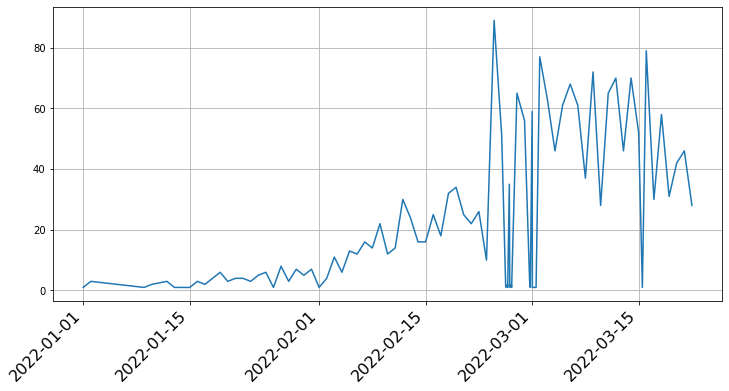

In [23]:
plt.figure(figsize=(12, 6))

data['date'].value_counts().sort_index().plot()
plt.xticks(rotation=45, fontsize=16);
plt.grid()

## Plot

In [24]:
data['marker-color'].value_counts()

#cc1b15    950
#005e38    700
#f18729    173
#444444    100
#ffcc00     62
Name: marker-color, dtype: int64

In [26]:
# No Crimea!
#world = gdp.read_file(
#    gdp.datasets.get_path('naturalearth_lowres'))
#world.loc[world['iso_a3'] == 'UKR', "geometry"].to_crs("EPSG:4326").iloc[0]

In [27]:
markers= {'#cc1b15' : "💢",
          '#005e38' : "🚛",
         '#f18729' : "💣",
         '#444444' : "❓",
         '#ffcc00' : "🎥"
        }

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import ft2font
from matplotlib.font_manager import ttfFontProperty
#plt.ioff()

fpath = '/usr/share/texlive/texmf-dist/fonts/truetype/google/noto-emoji/NotoEmoji-Regular.ttf'

font = ft2font.FT2Font(fpath)
fprop = fm.FontProperties(fname=fpath)

ttfFontProp = ttfFontProperty(font)

FONTSIZE = 18

fontprop = fm.FontProperties(family='sans-serif',
                            fname=ttfFontProp.fname,
                            size=FONTSIZE,
                            stretch=ttfFontProp.stretch,
                            style=ttfFontProp.style,
                            variant=ttfFontProp.variant,
                            weight=ttfFontProp.weight)

In [29]:
border = pd.DataFrame(ukraine_border)

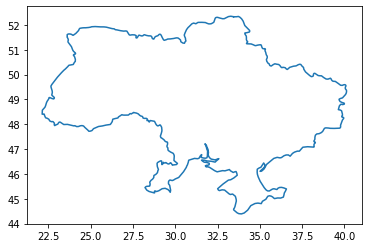

In [30]:
plt.plot(border[0], border[1], ls='-', marker='')

In [31]:
xlims = 22, 41
ylims = 44, 54

In [32]:
if not os.path.exists('tiles'):
    os.mkdir('tiles')

In [33]:
from itertools import product
from PIL import Image
import requests


import math
TILE_SIZE = 256

URL = "https://tile.openstreetmap.org/{z}/{x}/{y}.png".format


def point_to_pixels(lon, lat, zoom):
    """convert gps coordinates to web mercator"""
    r = math.pow(2, zoom) * TILE_SIZE
    lat = math.radians(lat)

    x = int((lon + 180.0) / 360.0 * r)
    y = int((1.0 - math.log(math.tan(lat) + (1.0 / math.cos(lat))) / math.pi) / 2.0 * r)

    return x, y

def get_tile(zoom, x_tile, y_tile):
    """
    Cache requested tiles.
    """
    f_tile = f'tiles/{zoom}_{x_tile}_{y_tile}.png'
    if not os.path.exists(f_tile):
        print(f"Downloading {f_tile}")
        with requests.get(URL(x=x_tile, y=y_tile, z=zoom)) as resp:
            cont = resp.content
        with open(f_tile, 'wb') as fout:
            fout.write(cont)

    return Image.open(f_tile)

def background_map(xlims, ylims, zoom):
    """
    Draw an OSM map background for the desired rectangle and zoom level.
    Adapted from https://bryanbrattlof.com/adding-openstreetmaps-to-matplotlib .
    """
    x0, y0 = point_to_pixels(xlims[0], ylims[1], zoom)
    x1, y1 = point_to_pixels(xlims[1], ylims[0], zoom)

    x0_tile, y0_tile = int(x0 / TILE_SIZE), int(y0 / TILE_SIZE)
    x1_tile, y1_tile = math.ceil(x1 / TILE_SIZE), math.ceil(y1 / TILE_SIZE)

    # full size image we'll add tiles to
    img = Image.new('RGB', (
        (x1_tile - x0_tile) * TILE_SIZE,
        (y1_tile - y0_tile) * TILE_SIZE))

    # loop through every tile inside our bounded box
    for x_tile, y_tile in product(range(x0_tile, x1_tile), range(y0_tile, y1_tile)):
        tile_img = get_tile(zoom, x_tile, y_tile)
        # add each tile to the full size image
        img.paste(
            im=tile_img,
            box=((x_tile - x0_tile) * TILE_SIZE, (y_tile - y0_tile) * TILE_SIZE))

        
    x0_out, y0_out = x0_tile * TILE_SIZE, y0_tile * TILE_SIZE

    margins = (x0-x0_out,
               y0-y0_out,
               x1-x0_out,
               y1-y0_out)

    img2 = img.crop(margins)

    # Show frame:
#    frame = Image.open('bitmap.png')
#    frame = frame.resize((x1-x0, y1-y0))
#    img.paste(im=frame, box=margins, mask=frame)

    plt.imshow(img2, extent=(xlims[0], xlims[1], ylims[0], ylims[1]))

In [34]:
def prepare_figure(offset=(0, 0)):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(border[0] + offset[0],
         border[1] + offset[1],
         ls='-', marker='', lw=5, alpha=.5)
    
    return fig

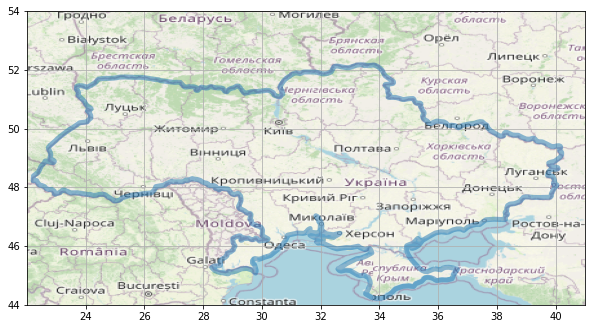

In [35]:
# Empirically computed offset as otherwise the borders don't match
# (and I've checked that the border coords seem to be correct)
offset = (+.08, -.18)

prepare_figure(offset)
background_map(xlims, ylims, 5)

plt.yticks(range(44, 55, 2))
plt.xticks(range(24, 41, 2))
plt.grid()


In [36]:
len(sorted(data['date'].unique()))

85

In [37]:
frames_count = 0
FRAMES_PER_DATE = 3
FRAMES_INTRO = FRAMES_PER_DATE * 10
FRAMES_OUTRO = FRAMES_PER_DATE * 10

In [38]:
descs = {'#005e38' : "movement and buildup\nof military assets",
         '#f18729' : "evidence of gunfire, bombing,\nshelling or explosion",
         '#cc1b15' : "civilian casualties, infrastructure\ndamage and military losses",
         '#ffcc00' : "other footage"
#         '#444444' : "❓",
        }

fig = plt.figure(figsize=(10, 6))

plt.annotate("Russian invasion of Ukraine, \n"
             "seen through verified videos",
             (.5, .75),
             size=20,
             fontsize=25,
             ha='center')


for i, c in enumerate(descs.keys()):
    print(c)
    y = .65-.18*i
    plt.annotate(markers[c],
                 (.21, y), size=20,
                 fontsize=FONTSIZE,
                 fontproperties=fprop,
                 color=c,
                 va='center'
                       )
    plt.annotate(descs[c],
                 (.3, y), size=20,
                 fontsize=FONTSIZE,
                 color=c,
                 va='center'
                       )

plt.axis('off')
fig.patch.set_facecolor((.7,.7,.7))
    
with warnings.catch_warnings():
    # Avoid "RuntimeWarning: Glyph 108 missing from current font."
    # - glyphs are apparently found, after all!
    warnings.simplefilter("ignore")

    for i in range(FRAMES_INTRO):
        plt.savefig(f'out/frame/frame_{frames_count:04}.png', dpi=300,
                    # Why these coords? Who knows. They work.
                    bbox_inches=Bbox([[1.25, .98], [8.99, 4.98]])
                   )
        frames_count += 1

    plt.close()


#005e38
#f18729
#cc1b15
#ffcc00


In [39]:
def plot_chunk(sample, alpha=1):
    gb = sample.groupby('marker-color')
    
    # Does not support emoji:
#    geoplot.pointplot(sample, ax=ax, color=color, marker=marker.get(color, 'd'), s=20)

    for j, (color, col_items) in enumerate(gb.groups.items()):
        subsample = data.loc[col_items]
        
        for idx, point in subsample.iterrows():
            ax.annotate(markers[color],
                        (point['long']+offset[0], point['lat']+offset[1]),
            ha="center",
            va="center",
            fontsize=FONTSIZE,
            fontproperties=fprop,
            color=color,
            alpha=alpha
                       )


start = data['date'].min()
end = data['date'].max()
# Start with February as there is little to show before:
start = pd.Timestamp('2022-02-01')


dates = pd.date_range(start, end)

past = [None]*3
opacities = [1, 1, 1, 1]
# opacities must be long len(past)*FRAMES_PER_DATE
opacities += list(np.arange(.8, 0,
                            -.8/(len(past)*FRAMES_PER_DATE - len(opacities))))

frames_n = len(dates) * FRAMES_PER_DATE
# Put a lower number for test:
#frames_n = 10
print(f"{start} to {dates[(frames_n-1)//FRAMES_PER_DATE]}, {frames_n} frames")
c = Counter(frames_n)

for i in range(frames_n):
    date = dates[i // FRAMES_PER_DATE]

    fig = prepare_figure(offset)
    background_map(xlims, ylims, 6)

    ax = plt.gca()
    ax.set_facecolor('#EEEEEE')

    sync = i % FRAMES_PER_DATE

    if sync == 0:
        sample = data.loc[data['date'] == date]
        past.insert(0, sample)
        past.pop()

    for lag, f in enumerate(past):
        if f is not None:
            plot_chunk(past[lag], alpha=opacities[lag*FRAMES_PER_DATE+sync])

    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    plt.grid(False)
    plt.axis('off')

    ax.annotate(date.strftime("%d/%m/%Y"),
                (23, 46.1),
                fontsize=20,
                color='b')

    box = Bbox([[xlims[0], ylims[0]], [xlims[1], ylims[1]]])
    plt.grid('on')
    with warnings.catch_warnings():
        # Avoid "RuntimeWarning: Glyph 108 missing from current font."
        # - glyphs are apparently found, after all!
        warnings.simplefilter("ignore")

        plt.savefig(f'out/frame/frame_{frames_count:04}.png', dpi=300,
                    # Why these coords? No idea. They work.
                    bbox_inches=Bbox([[1.25, .98], [8.99, 4.98]])
                   )

    frames_count += 1
    # Do not show images in notebook:
    plt.close()
    
    c.count()

2022-02-01 00:00:00 to 2022-03-22 00:00:00, 150 frames
.................................................. 50 of 150 (33.33%) after 90.03
.................................................. 100 of 150 (66.67%) after 189.28
.................................................. 150 of 150 (100.00%) after 291.24
 150 done in 291.24


In [40]:
fig = plt.figure(figsize=(10, 6))

plt.annotate("Data from the Russia-Ukraine Monitor Map: \n"
             "https://maphub.net/Cen4infoRes/russian-ukraine-monitor\n\n",
             (.5, .65),
             fontsize=17,
             ha='center',
             color='blue')

plt.annotate("The Russia-Ukraine Monitor Map is a crowdsourced effort by \n"
             "Centre for Information Resilience \n"
             "(https://twitter.com/Cen4infoRes), Bellingcat, Conflict \n"
             "Intelligence Team, Advance Democracy \n"
             "and the wider open source community \n"
             "to map, document and verify significant incidents \n"
             "during the conflict in Ukraine.",
             (.5, .75),
             fontsize=17,
             ha='center',
             va='top',
             color='b')

plt.annotate("Animation by Pietro Battiston \n"
             "https://pietrobattiston.it",
            (.5, .1),
            fontsize=17,
            ha='center',
            color='k')

fig.patch.set_facecolor((.7,.7,.7))

plt.axis('off')

with warnings.catch_warnings():
    # Avoid "RuntimeWarning: Glyph 108 missing from current font."
    # - glyphs are apparently found, after all!
    warnings.simplefilter("ignore")

    for i in range(FRAMES_OUTRO):
        plt.savefig(f'out/frame/frame_{frames_count:04}.png', dpi=300,
                    # Why these coords? Who knows. They work.
                    bbox_inches=Bbox([[1.25, .98], [8.99, 4.98]])
                   )
        frames_count += 1

    plt.close()

In [42]:
!ffmpeg -r 8 -f image2 -s 1920x1080 -i out/frame/frame_%04d.png\
-vcodec libx264 -crf 25 -pix_fmt yuv420p out/animap.mp4 -y

ffmpeg version 4.3.3-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 